In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import optuna
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization.matplotlib import plot_slice
from optuna.visualization.matplotlib import plot_parallel_coordinate
from sklearn.model_selection import StratifiedKFold
import time

In [2]:
df = pd.read_csv("../data/raw/covtype.csv")

In [3]:
print("\nData Frame Head:")
print(df.head())
print("\nData Frame info:")
print(df.info())



Data Frame Head:
   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       2596      51      3                               258   
1       2590      56      2                               212   
2       2804     139      9                               268   
3       2785     155     18                               242   
4       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            221             232            148   
1            220             235            151   
2            234 

In [4]:
numerical_df = df.iloc[:,:10]
num_cols = numerical_df.columns
print("\nData Frame numerical features:")
print(numerical_df.columns)

print("\nData Frame Description:")
print(df.describe())



Data Frame numerical features:
Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points'],
      dtype='object')

Data Frame Description:
           Elevation         Aspect          Slope  \
count  581012.000000  581012.000000  581012.000000   
mean     2959.365301     155.656807      14.103704   
std       279.984734     111.913721       7.488242   
min      1859.000000       0.000000       0.000000   
25%      2809.000000      58.000000       9.000000   
50%      2996.000000     127.000000      13.000000   
75%      3163.000000     260.000000      18.000000   
max      3858.000000     360.000000      66.000000   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                     581012.000000                   581012.000000   
mean                        

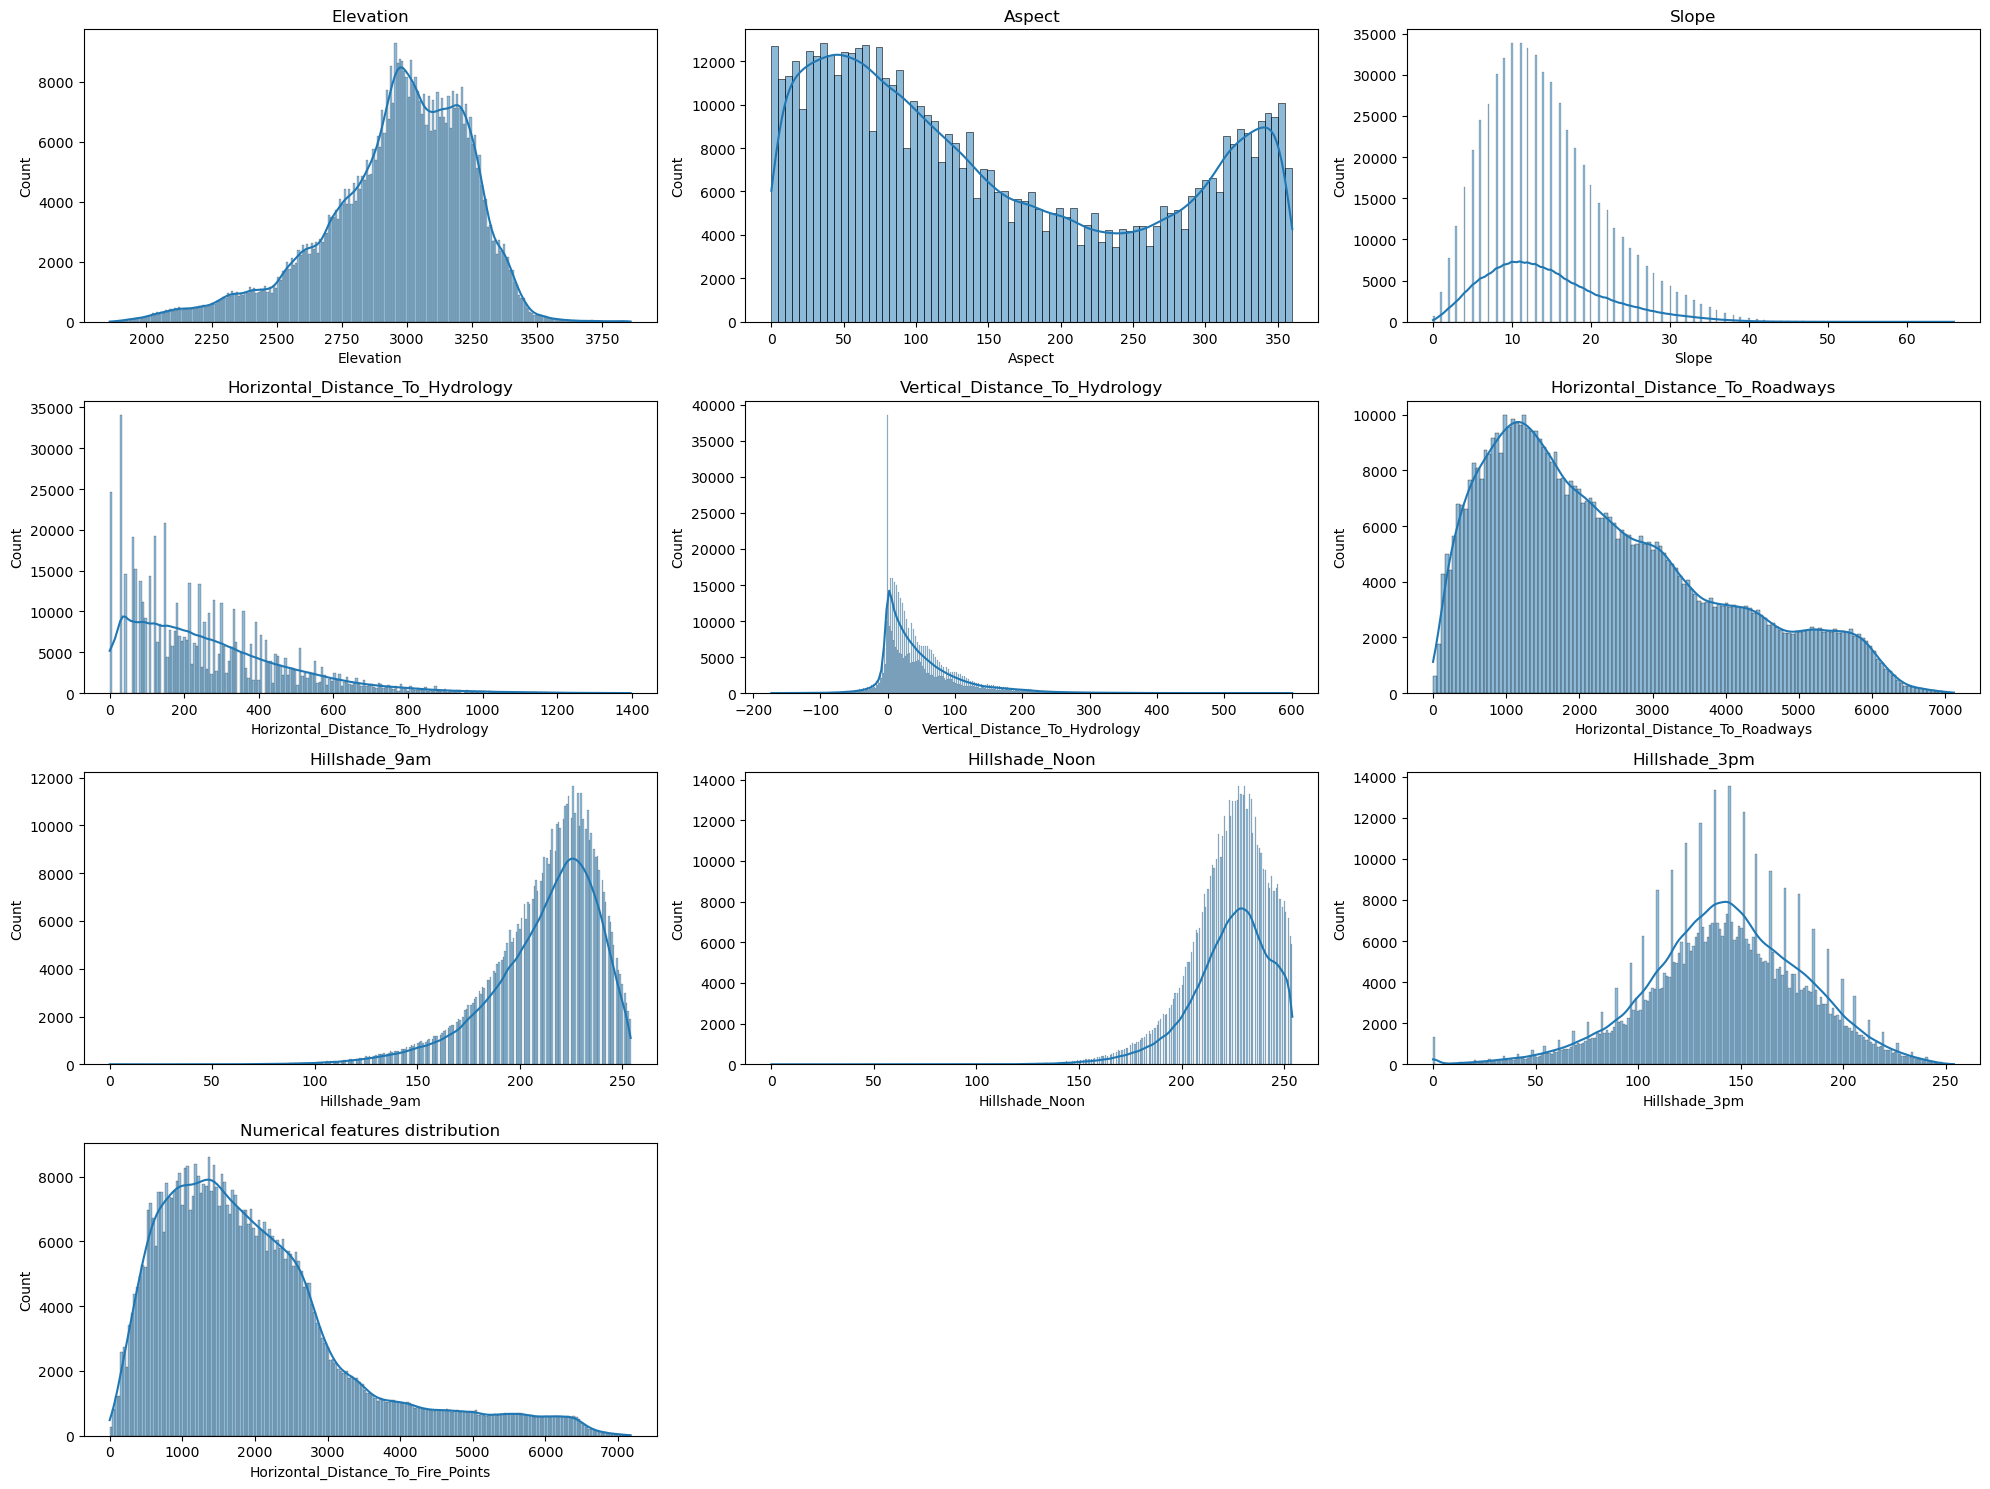

In [5]:
plt.figure(figsize=(20, 15))

for i, col in enumerate(numerical_df.columns):
    plt.subplot(4, 3, i + 1)  
    sns.histplot(numerical_df[col], kde=True)
    plt.title(col)

plt.tight_layout()
plt.title("Numerical features distribution")
plots_save_path = r"..\outputs\Numerical features distribution.png"
plt.savefig(plots_save_path, bbox_inches='tight', dpi=300)

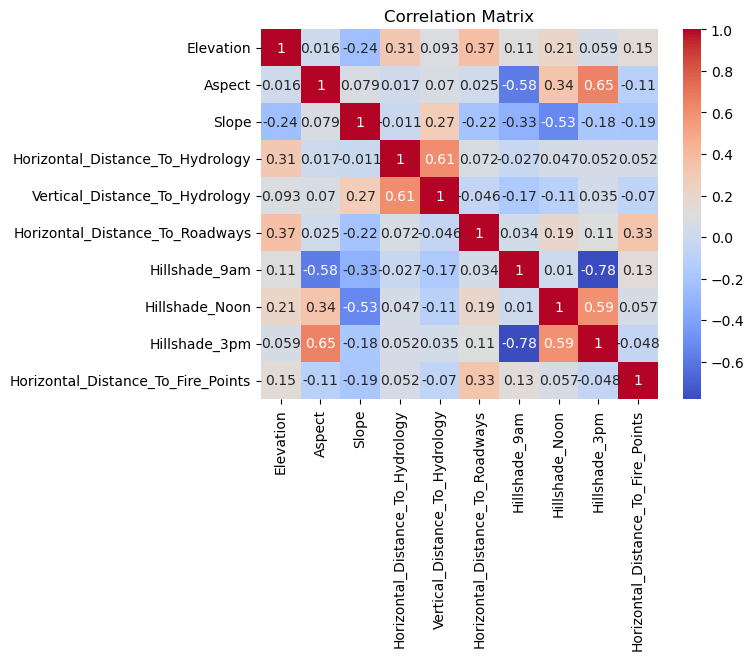

In [6]:
plt.figure()
sns.heatmap(numerical_df.corr() , annot=True , cmap='coolwarm')
plt.title("Correlation Matrix")
plots_save_path = r"..\outputs\Correlation Matrix.png"
plt.savefig(plots_save_path, bbox_inches='tight', dpi=300)


In [7]:
X = df.drop('Cover_Type' , axis = 1)
y = df['Cover_Type']
y = y - 1    # Map target labels to (0 -> 6) instead of (1 -> 7):

In [74]:
X_train , X_test , y_train , y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    stratify=y, 
    random_state = 42
)

In [9]:
print("\nTraining features description (Numerical Columns):")
print(X_train[num_cols].describe())

print("\nTest features description (Numerical Columns):")
print(X_test[num_cols].describe())

print("\nTraining target Shape:")
print(y_train.shape)
print("\nTest target Shape:")
print(y_test.shape)



Training features description (Numerical Columns):
           Elevation         Aspect          Slope  \
count  464809.000000  464809.000000  464809.000000   
mean     2959.064317     155.614248      14.097795   
std       280.114776     111.904089       7.486642   
min      1859.000000       0.000000       0.000000   
25%      2809.000000      58.000000       9.000000   
50%      2995.000000     127.000000      13.000000   
75%      3163.000000     260.000000      18.000000   
max      3858.000000     360.000000      66.000000   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                     464809.000000                   464809.000000   
mean                         269.317737                       46.370707   
std                          212.463863                       58.272807   
min                            0.000000                     -166.000000   
25%                          108.000000                        7.000000   
50%        

In [10]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[num_cols])
X_test_scaled = scaler.transform(X_test[num_cols])

X_train_scaled_df = pd.DataFrame(
    X_train_scaled,
    columns=num_cols,
    index=X_train.index
)
X_test_scaled_df = pd.DataFrame(
    X_test_scaled,
    columns=num_cols,
    index=X_test.index
)

In [11]:
print("\nTraining features description after scaling (Numerical Columns) :")
print(X_train_scaled_df.describe())

print("\nTest features description after scaling (Numerical Columns) :")
print(X_test_scaled_df.describe())


Training features description after scaling (Numerical Columns) :
          Elevation        Aspect         Slope  \
count  4.648090e+05  4.648090e+05  4.648090e+05   
mean   1.910235e-16 -1.114100e-16  6.400570e-17   
std    1.000001e+00  1.000001e+00  1.000001e+00   
min   -3.927196e+00 -1.390605e+00 -1.883062e+00   
25%   -5.357250e-01 -8.723037e-01 -6.809195e-01   
50%    1.282893e-01 -2.557036e-01 -1.466340e-01   
75%    7.280441e-01  9.328155e-01  5.212229e-01   
max    3.209173e+00  1.826439e+00  6.932649e+00   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                      4.648090e+05                    4.648090e+05   
mean                       1.425950e-16                    3.448695e-17   
std                        1.000001e+00                    1.000001e+00   
min                       -1.267595e+00                   -3.644426e+00   
25%                       -7.592722e-01                   -6.756282e-01   
50%                    

In [12]:
X_train_final_scaled = pd.concat([X_train_scaled_df , X_train.drop(num_cols , axis = 1)] , axis = 1)
X_test_final_scaled = pd.concat([X_test_scaled_df , X_test.drop(num_cols , axis = 1)] , axis = 1)

print("\nFinal Training set info:")
print(X_train_final_scaled.info())

print("\nFinal Test set info:")
print(X_test_final_scaled.info())


Final Training set info:
<class 'pandas.core.frame.DataFrame'>
Index: 464809 entries, 519924 to 121958
Data columns (total 54 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Elevation                           464809 non-null  float64
 1   Aspect                              464809 non-null  float64
 2   Slope                               464809 non-null  float64
 3   Horizontal_Distance_To_Hydrology    464809 non-null  float64
 4   Vertical_Distance_To_Hydrology      464809 non-null  float64
 5   Horizontal_Distance_To_Roadways     464809 non-null  float64
 6   Hillshade_9am                       464809 non-null  float64
 7   Hillshade_Noon                      464809 non-null  float64
 8   Hillshade_3pm                       464809 non-null  float64
 9   Horizontal_Distance_To_Fire_Points  464809 non-null  float64
 10  Wilderness_Area1                    464809 non-null  int64  
 11  

In [ ]:
models = {
    'Random_Forest' : RandomForestClassifier(random_state=42),
    'XGBoost' : XGBClassifier(random_state = 42)
}

In [15]:
results = {}
for name , model in models.items():
    model.fit(X_train_final_scaled , y_train)
    y_pred = model.predict(X_test_final_scaled)
    acc = accuracy_score(y_test , y_pred)
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    results[name] = y_pred

Random_Forest Accuracy: 0.9551
              precision    recall  f1-score   support

           0       0.97      0.94      0.95     42557
           1       0.95      0.97      0.96     56500
           2       0.94      0.96      0.95      7121
           3       0.91      0.85      0.88       526
           4       0.94      0.77      0.85      1995
           5       0.94      0.90      0.92      3489
           6       0.97      0.96      0.96      4015

    accuracy                           0.96    116203
   macro avg       0.95      0.91      0.93    116203
weighted avg       0.96      0.96      0.95    116203

XGBoost Accuracy: 0.8712
              precision    recall  f1-score   support

           0       0.86      0.84      0.85     42557
           1       0.87      0.90      0.88     56500
           2       0.90      0.91      0.91      7121
           3       0.91      0.86      0.89       526
           4       0.89      0.59      0.71      1995
           5       0.8

In [13]:
cm = confusion_matrix(y_test, results['Random_Forest'])
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(1, 8), yticklabels=range(1, 8))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of Random Forest')
plots_save_path = r"..\outputs\Confusion Matrix of Random Fores.png"
plt.savefig(plots_save_path, bbox_inches='tight', dpi=300)
plt.show()

NameError: name 'results' is not defined

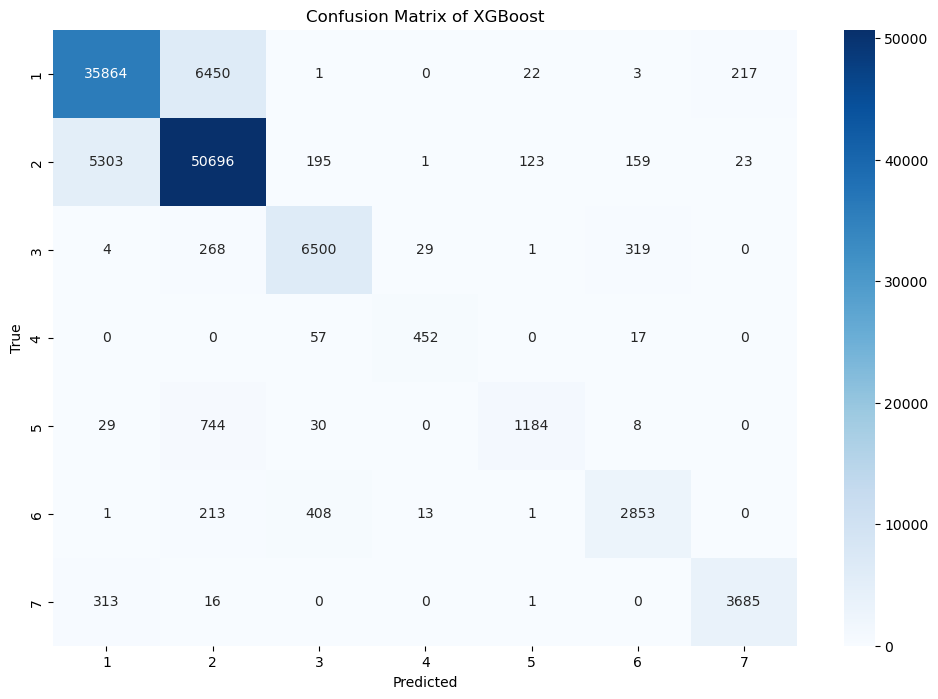

In [ ]:
cm = confusion_matrix(y_test, results['XGBoost'])
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(1, 8), yticklabels=range(1, 8))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of XGBoost')
plots_save_path = r"..\outputs\Confusion Matrix of XGBoost.png"
plt.savefig(plots_save_path, bbox_inches='tight', dpi=300)
plt.show()

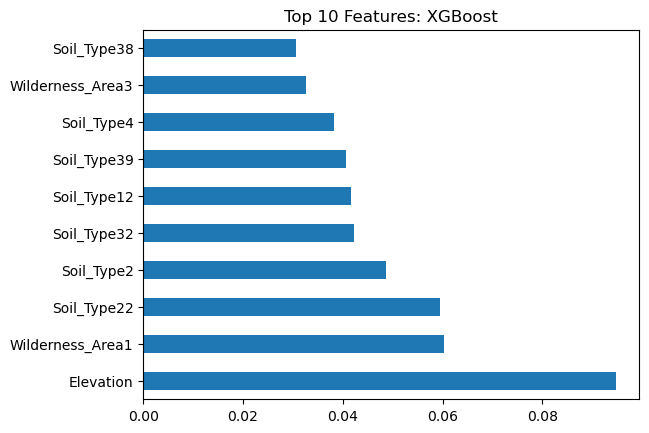

In [ ]:
xgb_importances = pd.Series(models['XGBoost'].feature_importances_, index=X.columns)
xgb_importances.nlargest(10).plot(kind='barh', title='Top 10 Features: XGBoost')
plots_save_path = r"..\outputs\Top 10 Features: XGBoost.png"
plt.savefig(plots_save_path, bbox_inches='tight', dpi=300)
plt.show()

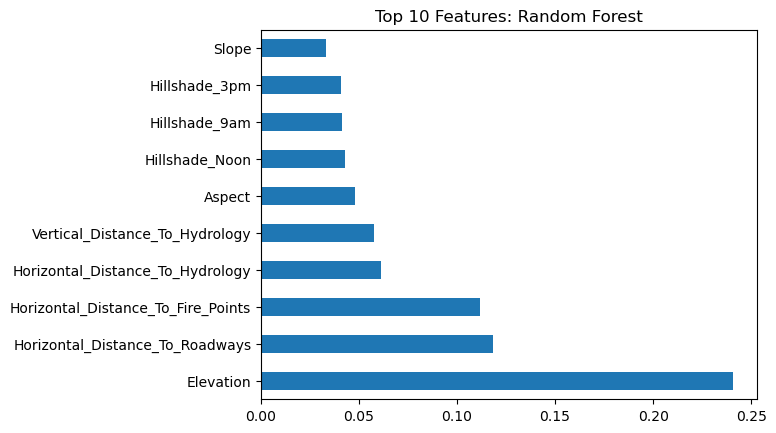

In [ ]:
feat_importances = pd.Series(models['Random_Forest'].feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', title='Top 10 Features: Random Forest')
plots_save_path = r"..\outputs\Top 10 Features: Random Forest.png"
plt.savefig(plots_save_path, bbox_inches='tight', dpi=300)
plt.show()

In [15]:
N_TRIALS = 40               # ~40 trials is a practical compromise for ~20 min on GPU
N_FOLDS = 5
EARLY_STOPPING_ROUNDS = 50  # early stop during fitting; reduces wasted epochs
RANDOM_STATE = 42

# Use gpu_hist for training and gpu_predictor for prediction
GPU_PARAMS = {
    "tree_method": "gpu_hist",      # critical for GPU acceleration
    "predictor": "gpu_predictor",
    "gpu_id": 0,
}

In [75]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

In [16]:
NUM_CLASSES = len(np.unique(y))

In [ ]:
def objective(trial):
    # search space
    param = {
        "verbosity": 0,
        "objective": "multi:softprob",
        "num_class": NUM_CLASSES,
        "eval_metric": "mlogloss",  # optuna pruning works on eval scores (we'll report accuracy manually)
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-8, 5.0),
        "subsample": trial.suggest_uniform("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 5.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0),
        # fix n_estimators to a large number but rely on early stopping
        "n_estimators": 2000,
        **GPU_PARAMS
    }

    # Stratified K-Fold CV: compute mean accuracy across folds
    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    accuracies = []
    fold_idx = 0

    for train_idx, valid_idx in skf.split(X, y):
        fold_idx += 1
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = XGBClassifier(**param, use_label_encoder=False , early_stopping_rounds = EARLY_STOPPING_ROUNDS)


        print(f"Trial {trial.number}, Fold {fold_idx}: Starting fit...")
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            verbose=False,
        )


        # use best_iteration if early stopped
        y_pred = model.predict(X_valid, iteration_range=(0, model.best_iteration + 1))
        acc = accuracy_score(y_valid, y_pred)
        accuracies.append(acc)

        # optional: quick pruning based on partial fold results (you can make it more aggressive)
        trial.report(np.mean(accuracies), fold_idx)
        if trial.should_prune():
            raise optuna.TrialPruned()
        print(f"Fold {fold_idx} done. Accuracy: {acc:.4f}, Best iteration: {model.best_iteration}")

    # final target: mean accuracy across folds (we maximize it)
    return float(np.mean(accuracies))


In [34]:
start = time.time()
# TPE sampler is a good default for continuous/discrete spaces
sampler = optuna.samplers.TPESampler(seed=RANDOM_STATE)
# MedianPruner will prune trials performing worse than median of previous trials
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=1, interval_steps=1)

# create study: direction="maximize" because we want highest accuracy
study = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner)
study.optimize(objective, n_trials=N_TRIALS, timeout=None)  # run tuning

# print best result
print("Study best trial:")
trial = study.best_trial
print("  Value (mean CV accuracy):", trial.value)
print("  Params: ")
for k, v in trial.params.items():
    print(f"    {k}: {v}")

print("Elapsed (s):", time.time() - start)

[I 2025-08-10 21:10:00,596] A new study created in memory with name: no-name-c5bf53a9-1495-439d-a4cd-7b978d618aae
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://git

Trial 0, Fold 1: Starting fit...
Fold 1 done. Accuracy: 0.9617, Best iteration: 1999
Trial 0, Fold 2: Starting fit...
Fold 2 done. Accuracy: 0.9624, Best iteration: 1999
Trial 0, Fold 3: Starting fit...
Fold 3 done. Accuracy: 0.9619, Best iteration: 1999
Trial 0, Fold 4: Starting fit...
Fold 4 done. Accuracy: 0.9619, Best iteration: 1999
Trial 0, Fold 5: Starting fit...


[I 2025-08-10 21:33:02,187] Trial 0 finished with value: 0.9621470815032517 and parameters: {'learning_rate': 0.03574712922600244, 'max_depth': 10, 'min_child_weight': 8.960785365368121, 'gamma': 0.001613289090029356, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.5779972601681014, 'reg_alpha': 3.200866785899844e-08, 'reg_lambda': 0.6245760287469893}. Best is trial 0 with value: 0.9621470815032517.


Fold 5 done. Accuracy: 0.9627, Best iteration: 1999


C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_logu

Trial 1, Fold 1: Starting fit...
Fold 1 done. Accuracy: 0.8862, Best iteration: 1651
Trial 1, Fold 2: Starting fit...
Fold 2 done. Accuracy: 0.8847, Best iteration: 1002
Trial 1, Fold 3: Starting fit...
Fold 3 done. Accuracy: 0.8843, Best iteration: 1146
Trial 1, Fold 4: Starting fit...
Fold 4 done. Accuracy: 0.8857, Best iteration: 896
Trial 1, Fold 5: Starting fit...


[I 2025-08-10 21:38:48,688] Trial 1 finished with value: 0.8854825718842549 and parameters: {'learning_rate': 0.07725378389307355, 'max_depth': 8, 'min_child_weight': 1.0636066512540283, 'gamma': 2.7366339528977597, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6061695553391381, 'reg_alpha': 3.8167167932852713e-07, 'reg_lambda': 4.4734294104626844e-07}. Best is trial 0 with value: 0.9621470815032517.


Fold 5 done. Accuracy: 0.8865, Best iteration: 1757


C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_logu

Trial 2, Fold 1: Starting fit...
Fold 1 done. Accuracy: 0.9223, Best iteration: 1999
Trial 2, Fold 2: Starting fit...
Fold 2 done. Accuracy: 0.9231, Best iteration: 1999
Trial 2, Fold 3: Starting fit...
Fold 3 done. Accuracy: 0.9241, Best iteration: 1999
Trial 2, Fold 4: Starting fit...
Fold 4 done. Accuracy: 0.9236, Best iteration: 1999
Trial 2, Fold 5: Starting fit...


[I 2025-08-10 22:11:39,212] Trial 2 finished with value: 0.923309675461524 and parameters: {'learning_rate': 0.028145092716060652, 'max_depth': 7, 'min_child_weight': 3.6473162849112093, 'gamma': 3.415022386605045e-06, 'subsample': 0.8447411578889518, 'colsample_bytree': 0.569746930326021, 'reg_alpha': 3.4782238967388167e-06, 'reg_lambda': 1.9826980964985924e-05}. Best is trial 0 with value: 0.9621470815032517.


Fold 5 done. Accuracy: 0.9234, Best iteration: 1999


C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_logu

Trial 3, Fold 1: Starting fit...
Fold 1 done. Accuracy: 0.9644, Best iteration: 1999
Trial 3, Fold 2: Starting fit...
Fold 2 done. Accuracy: 0.9655, Best iteration: 1999
Trial 3, Fold 3: Starting fit...
Fold 3 done. Accuracy: 0.9643, Best iteration: 1999
Trial 3, Fold 4: Starting fit...
Fold 4 done. Accuracy: 0.9649, Best iteration: 1999
Trial 3, Fold 5: Starting fit...


[I 2025-08-10 23:20:56,490] Trial 3 finished with value: 0.9649611368159935 and parameters: {'learning_rate': 0.04717052037625178, 'max_depth': 9, 'min_child_weight': 1.8187859051288213, 'gamma': 0.0002973787659849158, 'subsample': 0.836965827544817, 'colsample_bytree': 0.5232252063599989, 'reg_alpha': 0.0019275890163896973, 'reg_lambda': 3.425445902633376e-07}. Best is trial 3 with value: 0.9649611368159935.


Fold 5 done. Accuracy: 0.9657, Best iteration: 1999


C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_logu

Trial 4, Fold 1: Starting fit...
Fold 1 done. Accuracy: 0.9303, Best iteration: 1999
Trial 4, Fold 2: Starting fit...
Fold 2 done. Accuracy: 0.9304, Best iteration: 1999
Trial 4, Fold 3: Starting fit...
Fold 3 done. Accuracy: 0.9313, Best iteration: 1999
Trial 4, Fold 4: Starting fit...
Fold 4 done. Accuracy: 0.9305, Best iteration: 1999
Trial 4, Fold 5: Starting fit...


[I 2025-08-11 00:13:52,720] Trial 4 finished with value: 0.9306967854686606 and parameters: {'learning_rate': 0.012476394272569451, 'max_depth': 10, 'min_child_weight': 18.043311207136256, 'gamma': 0.10770212765048791, 'subsample': 0.7218455076693483, 'colsample_bytree': 0.5488360570031919, 'reg_alpha': 0.00895617505524071, 'reg_lambda': 9.148975058772307e-05}. Best is trial 3 with value: 0.9649611368159935.


Fold 5 done. Accuracy: 0.9310, Best iteration: 1999


C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_logu

Trial 5, Fold 1: Starting fit...


[I 2025-08-11 00:16:43,445] Trial 5 pruned. 
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log

Trial 6, Fold 1: Starting fit...


[I 2025-08-11 00:19:00,301] Trial 6 pruned. 
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log

Trial 7, Fold 1: Starting fit...


[I 2025-08-11 00:21:15,857] Trial 7 pruned. 
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log

Trial 8, Fold 1: Starting fit...
Fold 1 done. Accuracy: 0.9346, Best iteration: 1999
Trial 8, Fold 2: Starting fit...
Fold 2 done. Accuracy: 0.9353, Best iteration: 1999
Trial 8, Fold 3: Starting fit...
Fold 3 done. Accuracy: 0.9359, Best iteration: 1999
Trial 8, Fold 4: Starting fit...
Fold 4 done. Accuracy: 0.9358, Best iteration: 1999
Trial 8, Fold 5: Starting fit...


[I 2025-08-11 00:38:11,310] Trial 8 finished with value: 0.935454002625581 and parameters: {'learning_rate': 0.026000059117302653, 'max_depth': 7, 'min_child_weight': 1.5252697030515172, 'gamma': 0.0951234237106025, 'subsample': 0.6298202574719083, 'colsample_bytree': 0.9934434683002586, 'reg_alpha': 0.05220764268782494, 'reg_lambda': 6.143857495033091e-07}. Best is trial 3 with value: 0.9649611368159935.


Fold 5 done. Accuracy: 0.9356, Best iteration: 1999


C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_logu

Trial 9, Fold 1: Starting fit...


[I 2025-08-11 00:41:59,562] Trial 9 pruned. 
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log

Trial 10, Fold 1: Starting fit...
Fold 1 done. Accuracy: 0.9640, Best iteration: 1999
Trial 10, Fold 2: Starting fit...
Fold 2 done. Accuracy: 0.9641, Best iteration: 1999
Trial 10, Fold 3: Starting fit...
Fold 3 done. Accuracy: 0.9638, Best iteration: 1999
Trial 10, Fold 4: Starting fit...
Fold 4 done. Accuracy: 0.9640, Best iteration: 1999
Trial 10, Fold 5: Starting fit...


[I 2025-08-11 00:58:19,114] Trial 10 finished with value: 0.9641453192448658 and parameters: {'learning_rate': 0.23020919308550297, 'max_depth': 6, 'min_child_weight': 2.513734458845408, 'gamma': 1.4330119670473818e-08, 'subsample': 0.8262452362725612, 'colsample_bytree': 0.713406447691657, 'reg_alpha': 2.233659295444868, 'reg_lambda': 1.2784194237583953e-08}. Best is trial 3 with value: 0.9649611368159935.


Fold 5 done. Accuracy: 0.9648, Best iteration: 1999


C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_logu

Trial 11, Fold 1: Starting fit...
Fold 1 done. Accuracy: 0.9503, Best iteration: 1999
Trial 11, Fold 2: Starting fit...
Fold 2 done. Accuracy: 0.9511, Best iteration: 1999
Trial 11, Fold 3: Starting fit...
Fold 3 done. Accuracy: 0.9511, Best iteration: 1999
Trial 11, Fold 4: Starting fit...
Fold 4 done. Accuracy: 0.9513, Best iteration: 1999
Trial 11, Fold 5: Starting fit...


[I 2025-08-11 01:12:47,794] Trial 11 finished with value: 0.9511387043901631 and parameters: {'learning_rate': 0.21312951441546218, 'max_depth': 5, 'min_child_weight': 2.636570377385442, 'gamma': 1.410918102664006e-08, 'subsample': 0.8279679066657979, 'colsample_bytree': 0.7171781358782057, 'reg_alpha': 3.82876009154686, 'reg_lambda': 1.2536269325652276e-08}. Best is trial 3 with value: 0.9649611368159935.


Fold 5 done. Accuracy: 0.9519, Best iteration: 1999


C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_logu

Trial 12, Fold 1: Starting fit...
Fold 1 done. Accuracy: 0.9627, Best iteration: 1999
Trial 12, Fold 2: Starting fit...
Fold 2 done. Accuracy: 0.9634, Best iteration: 1999
Trial 12, Fold 3: Starting fit...
Fold 3 done. Accuracy: 0.9635, Best iteration: 1999
Trial 12, Fold 4: Starting fit...
Fold 4 done. Accuracy: 0.9634, Best iteration: 1999
Trial 12, Fold 5: Starting fit...


[I 2025-08-11 01:28:37,586] Trial 12 finished with value: 0.963467193276171 and parameters: {'learning_rate': 0.2908589003717836, 'max_depth': 6, 'min_child_weight': 2.225171016411918, 'gamma': 1.1405837930252884e-08, 'subsample': 0.8612012640576854, 'colsample_bytree': 0.7159779624208231, 'reg_alpha': 4.591709200186302, 'reg_lambda': 0.0074839487022762274}. Best is trial 3 with value: 0.9649611368159935.


Fold 5 done. Accuracy: 0.9644, Best iteration: 1999


C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_logu

Trial 13, Fold 1: Starting fit...
Fold 1 done. Accuracy: 0.9700, Best iteration: 1999
Trial 13, Fold 2: Starting fit...
Fold 2 done. Accuracy: 0.9706, Best iteration: 1998
Trial 13, Fold 3: Starting fit...
Fold 3 done. Accuracy: 0.9701, Best iteration: 1999
Trial 13, Fold 4: Starting fit...
Fold 4 done. Accuracy: 0.9701, Best iteration: 1998
Trial 13, Fold 5: Starting fit...


[I 2025-08-11 01:47:41,768] Trial 13 finished with value: 0.9703345198069376 and parameters: {'learning_rate': 0.12718920014005627, 'max_depth': 8, 'min_child_weight': 2.1632869872585965, 'gamma': 1.1084112638235652e-05, 'subsample': 0.7882622659595899, 'colsample_bytree': 0.8304278626461434, 'reg_alpha': 0.00018258877760458727, 'reg_lambda': 1.0523297824440093e-08}. Best is trial 13 with value: 0.9703345198069376.


Fold 5 done. Accuracy: 0.9708, Best iteration: 1999


C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_logu

Trial 14, Fold 1: Starting fit...
Fold 1 done. Accuracy: 0.9683, Best iteration: 1999
Trial 14, Fold 2: Starting fit...
Fold 2 done. Accuracy: 0.9687, Best iteration: 1999
Trial 14, Fold 3: Starting fit...
Fold 3 done. Accuracy: 0.9686, Best iteration: 1999
Trial 14, Fold 4: Starting fit...
Fold 4 done. Accuracy: 0.9686, Best iteration: 1999
Trial 14, Fold 5: Starting fit...


[I 2025-08-11 02:06:35,163] Trial 14 finished with value: 0.9686787885753809 and parameters: {'learning_rate': 0.09850065883213212, 'max_depth': 8, 'min_child_weight': 4.433258010720939, 'gamma': 9.604569529454616e-05, 'subsample': 0.7789497464684081, 'colsample_bytree': 0.8633753186051893, 'reg_alpha': 0.00010469415159803921, 'reg_lambda': 2.4198546875244328e-06}. Best is trial 13 with value: 0.9703345198069376.


Fold 5 done. Accuracy: 0.9691, Best iteration: 1999


C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_logu

Trial 15, Fold 1: Starting fit...
Fold 1 done. Accuracy: 0.9684, Best iteration: 1998
Trial 15, Fold 2: Starting fit...
Fold 2 done. Accuracy: 0.9695, Best iteration: 1999
Trial 15, Fold 3: Starting fit...
Fold 3 done. Accuracy: 0.9687, Best iteration: 1999
Trial 15, Fold 4: Starting fit...
Fold 4 done. Accuracy: 0.9688, Best iteration: 1998
Trial 15, Fold 5: Starting fit...


[I 2025-08-11 02:25:17,087] Trial 15 finished with value: 0.9689903135147355 and parameters: {'learning_rate': 0.11764105905894624, 'max_depth': 8, 'min_child_weight': 5.333517422203261, 'gamma': 6.654784281720537e-06, 'subsample': 0.7809305251510433, 'colsample_bytree': 0.834573804356066, 'reg_alpha': 0.0001501297099819159, 'reg_lambda': 3.901069568054151e-06}. Best is trial 13 with value: 0.9703345198069376.


Fold 5 done. Accuracy: 0.9696, Best iteration: 1999


C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_logu

Trial 16, Fold 1: Starting fit...
Fold 1 done. Accuracy: 0.9681, Best iteration: 1999
Trial 16, Fold 2: Starting fit...
Fold 2 done. Accuracy: 0.9688, Best iteration: 1999
Trial 16, Fold 3: Starting fit...
Fold 3 done. Accuracy: 0.9684, Best iteration: 1999
Trial 16, Fold 4: Starting fit...
Fold 4 done. Accuracy: 0.9683, Best iteration: 1999
Trial 16, Fold 5: Starting fit...


[I 2025-08-11 02:43:41,090] Trial 16 finished with value: 0.9685376553431098 and parameters: {'learning_rate': 0.12989807912717755, 'max_depth': 8, 'min_child_weight': 6.2590402224375605, 'gamma': 9.049635194257052e-07, 'subsample': 0.7493783786668422, 'colsample_bytree': 0.8182277125733659, 'reg_alpha': 0.00017426632622971722, 'reg_lambda': 0.0056913618241371715}. Best is trial 13 with value: 0.9703345198069376.


Fold 5 done. Accuracy: 0.9691, Best iteration: 1999


C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_logu

Trial 17, Fold 1: Starting fit...
Fold 1 done. Accuracy: 0.9710, Best iteration: 1880
Trial 17, Fold 2: Starting fit...
Fold 2 done. Accuracy: 0.9715, Best iteration: 1762
Trial 17, Fold 3: Starting fit...
Fold 3 done. Accuracy: 0.9711, Best iteration: 1866
Trial 17, Fold 4: Starting fit...
Fold 4 done. Accuracy: 0.9712, Best iteration: 1998
Trial 17, Fold 5: Starting fit...


[I 2025-08-11 03:03:02,838] Trial 17 finished with value: 0.9712346732907097 and parameters: {'learning_rate': 0.1402663735041712, 'max_depth': 9, 'min_child_weight': 3.670752122283532, 'gamma': 2.846405507440076e-07, 'subsample': 0.8937243027997998, 'colsample_bytree': 0.9052130298289511, 'reg_alpha': 5.0090475467468006e-05, 'reg_lambda': 3.0458103267083488e-06}. Best is trial 17 with value: 0.9712346732907097.


Fold 5 done. Accuracy: 0.9714, Best iteration: 1968


C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_logu

Trial 18, Fold 1: Starting fit...
Fold 1 done. Accuracy: 0.9711, Best iteration: 1590
Trial 18, Fold 2: Starting fit...
Fold 2 done. Accuracy: 0.9714, Best iteration: 1625
Trial 18, Fold 3: Starting fit...
Fold 3 done. Accuracy: 0.9708, Best iteration: 1462
Trial 18, Fold 4: Starting fit...
Fold 4 done. Accuracy: 0.9711, Best iteration: 1647
Trial 18, Fold 5: Starting fit...


[I 2025-08-11 03:19:27,153] Trial 18 finished with value: 0.9711864813194678 and parameters: {'learning_rate': 0.16152009779421803, 'max_depth': 9, 'min_child_weight': 3.3837452406243997, 'gamma': 2.9920853593057816e-07, 'subsample': 0.8885370075616948, 'colsample_bytree': 0.9069968527889158, 'reg_alpha': 4.547772378575939e-07, 'reg_lambda': 5.2508714373135436e-08}. Best is trial 17 with value: 0.9712346732907097.


Fold 5 done. Accuracy: 0.9716, Best iteration: 1504


C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_logu

Trial 19, Fold 1: Starting fit...
Fold 1 done. Accuracy: 0.9710, Best iteration: 1368
Trial 19, Fold 2: Starting fit...
Fold 2 done. Accuracy: 0.9718, Best iteration: 1410
Trial 19, Fold 3: Starting fit...
Fold 3 done. Accuracy: 0.9708, Best iteration: 1316
Trial 19, Fold 4: Starting fit...
Fold 4 done. Accuracy: 0.9707, Best iteration: 1226
Trial 19, Fold 5: Starting fit...


[I 2025-08-11 03:33:08,557] Trial 19 finished with value: 0.9712019709198992 and parameters: {'learning_rate': 0.19558986295656192, 'max_depth': 9, 'min_child_weight': 3.45771974100606, 'gamma': 2.3509276678316362e-07, 'subsample': 0.9108457069756034, 'colsample_bytree': 0.9134336554829188, 'reg_alpha': 1.1496058865250678e-08, 'reg_lambda': 0.0005969970084796424}. Best is trial 17 with value: 0.9712346732907097.


Fold 5 done. Accuracy: 0.9717, Best iteration: 1298


C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_logu

Trial 20, Fold 1: Starting fit...
Fold 1 done. Accuracy: 0.9703, Best iteration: 1800
Trial 20, Fold 2: Starting fit...
Fold 2 done. Accuracy: 0.9707, Best iteration: 1995
Trial 20, Fold 3: Starting fit...
Fold 3 done. Accuracy: 0.9703, Best iteration: 1819
Trial 20, Fold 4: Starting fit...
Fold 4 done. Accuracy: 0.9704, Best iteration: 1993
Trial 20, Fold 5: Starting fit...


[I 2025-08-11 03:51:53,285] Trial 20 finished with value: 0.9705117966843811 and parameters: {'learning_rate': 0.18272532293320745, 'max_depth': 10, 'min_child_weight': 11.82690915171999, 'gamma': 1.4806460266267277e-07, 'subsample': 0.9965108784574399, 'colsample_bytree': 0.9169675388319403, 'reg_alpha': 1.4028441301816202e-08, 'reg_lambda': 0.0017377542249006836}. Best is trial 17 with value: 0.9712346732907097.


Fold 5 done. Accuracy: 0.9709, Best iteration: 1802


C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_logu

Trial 21, Fold 1: Starting fit...
Fold 1 done. Accuracy: 0.9707, Best iteration: 1410
Trial 21, Fold 2: Starting fit...
Fold 2 done. Accuracy: 0.9717, Best iteration: 1572
Trial 21, Fold 3: Starting fit...
Fold 3 done. Accuracy: 0.9712, Best iteration: 1508
Trial 21, Fold 4: Starting fit...
Fold 4 done. Accuracy: 0.9709, Best iteration: 1467
Trial 21, Fold 5: Starting fit...


[I 2025-08-11 04:07:24,305] Trial 21 finished with value: 0.9712054140308874 and parameters: {'learning_rate': 0.17032961140159647, 'max_depth': 9, 'min_child_weight': 3.262293088241617, 'gamma': 2.265827952181792e-07, 'subsample': 0.8987795437451007, 'colsample_bytree': 0.9054240592480829, 'reg_alpha': 3.464082511732643e-07, 'reg_lambda': 0.049226309941908}. Best is trial 17 with value: 0.9712346732907097.


Fold 5 done. Accuracy: 0.9715, Best iteration: 1495


C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_logu

Trial 22, Fold 1: Starting fit...
Fold 1 done. Accuracy: 0.9703, Best iteration: 1028
Trial 22, Fold 2: Starting fit...
Fold 2 done. Accuracy: 0.9713, Best iteration: 1090
Trial 22, Fold 3: Starting fit...
Fold 3 done. Accuracy: 0.9708, Best iteration: 1043
Trial 22, Fold 4: Starting fit...
Fold 4 done. Accuracy: 0.9705, Best iteration: 1010
Trial 22, Fold 5: Starting fit...


[I 2025-08-11 04:18:11,203] Trial 22 finished with value: 0.9707475920222233 and parameters: {'learning_rate': 0.26690613222441456, 'max_depth': 9, 'min_child_weight': 3.567934195328463, 'gamma': 9.644986633541663e-08, 'subsample': 0.9413545155525437, 'colsample_bytree': 0.7719460346219307, 'reg_alpha': 1.0427363729076038e-07, 'reg_lambda': 0.06998677110444267}. Best is trial 17 with value: 0.9712346732907097.


Fold 5 done. Accuracy: 0.9709, Best iteration: 1029


C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_logu

Trial 23, Fold 1: Starting fit...
Fold 1 done. Accuracy: 0.9709, Best iteration: 1203
Trial 23, Fold 2: Starting fit...
Fold 2 done. Accuracy: 0.9719, Best iteration: 1382
Trial 23, Fold 3: Starting fit...
Fold 3 done. Accuracy: 0.9710, Best iteration: 1315
Trial 23, Fold 4: Starting fit...
Fold 4 done. Accuracy: 0.9712, Best iteration: 1289
Trial 23, Fold 5: Starting fit...


[I 2025-08-11 04:32:43,045] Trial 23 finished with value: 0.9714377672945463 and parameters: {'learning_rate': 0.16114962836168453, 'max_depth': 10, 'min_child_weight': 5.058198413559108, 'gamma': 9.423172895697571e-07, 'subsample': 0.8829763887111723, 'colsample_bytree': 0.9848024319125552, 'reg_alpha': 2.5693855451456057e-07, 'reg_lambda': 0.07558293169618256}. Best is trial 23 with value: 0.9714377672945463.


Fold 5 done. Accuracy: 0.9721, Best iteration: 1318


C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_logu

Trial 24, Fold 1: Starting fit...
Fold 1 done. Accuracy: 0.9714, Best iteration: 1995
Trial 24, Fold 2: Starting fit...
Fold 2 done. Accuracy: 0.9719, Best iteration: 1997
Trial 24, Fold 3: Starting fit...
Fold 3 done. Accuracy: 0.9713, Best iteration: 1999
Trial 24, Fold 4: Starting fit...
Fold 4 done. Accuracy: 0.9713, Best iteration: 1994
Trial 24, Fold 5: Starting fit...


[I 2025-08-11 04:54:36,486] Trial 24 finished with value: 0.9716236497129241 and parameters: {'learning_rate': 0.09090142966325086, 'max_depth': 10, 'min_child_weight': 5.103542285416189, 'gamma': 1.754596668040114e-06, 'subsample': 0.8769800648263205, 'colsample_bytree': 0.9876294280886639, 'reg_alpha': 6.21617995700303e-07, 'reg_lambda': 0.09015118712751387}. Best is trial 24 with value: 0.9716236497129241.


Fold 5 done. Accuracy: 0.9722, Best iteration: 1991


C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_logu

Trial 25, Fold 1: Starting fit...
Fold 1 done. Accuracy: 0.9707, Best iteration: 1999
Trial 25, Fold 2: Starting fit...
Fold 2 done. Accuracy: 0.9709, Best iteration: 1999
Trial 25, Fold 3: Starting fit...
Fold 3 done. Accuracy: 0.9707, Best iteration: 1999
Trial 25, Fold 4: Starting fit...
Fold 4 done. Accuracy: 0.9706, Best iteration: 1999
Trial 25, Fold 5: Starting fit...


[I 2025-08-11 05:17:42,396] Trial 25 finished with value: 0.9708353701867891 and parameters: {'learning_rate': 0.08834132892815763, 'max_depth': 10, 'min_child_weight': 6.534702010807306, 'gamma': 4.041301524312617e-05, 'subsample': 0.8730385603036959, 'colsample_bytree': 0.98257557852481, 'reg_alpha': 2.103793769721419e-05, 'reg_lambda': 9.879192474391198}. Best is trial 24 with value: 0.9716236497129241.


Fold 5 done. Accuracy: 0.9713, Best iteration: 1999


C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_logu

Trial 26, Fold 1: Starting fit...
Fold 1 done. Accuracy: 0.9704, Best iteration: 1999
Trial 26, Fold 2: Starting fit...
Fold 2 done. Accuracy: 0.9715, Best iteration: 1999
Trial 26, Fold 3: Starting fit...
Fold 3 done. Accuracy: 0.9707, Best iteration: 1999
Trial 26, Fold 4: Starting fit...
Fold 4 done. Accuracy: 0.9708, Best iteration: 1999
Trial 26, Fold 5: Starting fit...


[I 2025-08-11 05:39:46,847] Trial 26 finished with value: 0.970988551167481 and parameters: {'learning_rate': 0.058896738688247186, 'max_depth': 10, 'min_child_weight': 4.672371576820018, 'gamma': 1.3404692187513022e-06, 'subsample': 0.9533488556444156, 'colsample_bytree': 0.9605786832560929, 'reg_alpha': 2.32520954996056e-06, 'reg_lambda': 0.1647689159926773}. Best is trial 24 with value: 0.9716236497129241.


Fold 5 done. Accuracy: 0.9716, Best iteration: 1999


C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_logu

Trial 27, Fold 1: Starting fit...


[I 2025-08-11 05:41:47,436] Trial 27 pruned. 
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 28, Fold 1: Starting fit...
Fold 1 done. Accuracy: 0.9701, Best iteration: 1989
Trial 28, Fold 2: Starting fit...
Fold 2 done. Accuracy: 0.9707, Best iteration: 1988
Trial 28, Fold 3: Starting fit...
Fold 3 done. Accuracy: 0.9701, Best iteration: 1995
Trial 28, Fold 4: Starting fit...
Fold 4 done. Accuracy: 0.9699, Best iteration: 1998
Trial 28, Fold 5: Starting fit...


[I 2025-08-11 06:02:07,185] Trial 28 finished with value: 0.9704343457051123 and parameters: {'learning_rate': 0.1462218925115168, 'max_depth': 10, 'min_child_weight': 11.737834836197658, 'gamma': 0.0003815495179624934, 'subsample': 0.9251997005246505, 'colsample_bytree': 0.9423793110209899, 'reg_alpha': 2.4856728348370433e-05, 'reg_lambda': 0.64996240542523}. Best is trial 24 with value: 0.9716236497129241.


Fold 5 done. Accuracy: 0.9713, Best iteration: 1998


C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_logu

Trial 29, Fold 1: Starting fit...


[I 2025-08-11 06:06:30,833] Trial 29 pruned. 
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 30, Fold 1: Starting fit...


[I 2025-08-11 06:09:48,369] Trial 30 pruned. 
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 31, Fold 1: Starting fit...
Fold 1 done. Accuracy: 0.9716, Best iteration: 1494
Trial 31, Fold 2: Starting fit...
Fold 2 done. Accuracy: 0.9721, Best iteration: 1528
Trial 31, Fold 3: Starting fit...
Fold 3 done. Accuracy: 0.9712, Best iteration: 1537
Trial 31, Fold 4: Starting fit...
Fold 4 done. Accuracy: 0.9713, Best iteration: 1435
Trial 31, Fold 5: Starting fit...


[I 2025-08-11 06:25:17,830] Trial 31 finished with value: 0.9716770044843994 and parameters: {'learning_rate': 0.1625079385322765, 'max_depth': 9, 'min_child_weight': 2.765788243622677, 'gamma': 1.0788711280007414e-06, 'subsample': 0.8907308124899289, 'colsample_bytree': 0.9570888782306983, 'reg_alpha': 7.084207393665136e-07, 'reg_lambda': 0.05063513448307449}. Best is trial 31 with value: 0.9716770044843994.


Fold 5 done. Accuracy: 0.9723, Best iteration: 1511


C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_logu

Trial 32, Fold 1: Starting fit...


[I 2025-08-11 06:29:18,419] Trial 32 pruned. 
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 33, Fold 1: Starting fit...
Fold 1 done. Accuracy: 0.9717, Best iteration: 1483
Trial 33, Fold 2: Starting fit...
Fold 2 done. Accuracy: 0.9723, Best iteration: 1406
Trial 33, Fold 3: Starting fit...
Fold 3 done. Accuracy: 0.9715, Best iteration: 1420
Trial 33, Fold 4: Starting fit...
Fold 4 done. Accuracy: 0.9714, Best iteration: 1417
Trial 33, Fold 5: Starting fit...


[I 2025-08-11 06:46:49,238] Trial 33 finished with value: 0.971897309866334 and parameters: {'learning_rate': 0.14729443029241493, 'max_depth': 10, 'min_child_weight': 2.6945548183026444, 'gamma': 8.305363556644857e-07, 'subsample': 0.8621183855996809, 'colsample_bytree': 0.9363176555206899, 'reg_alpha': 4.7504186266494736e-08, 'reg_lambda': 3.343843633977881}. Best is trial 33 with value: 0.971897309866334.


Fold 5 done. Accuracy: 0.9725, Best iteration: 1504


C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_logu

Trial 34, Fold 1: Starting fit...
Fold 1 done. Accuracy: 0.9722, Best iteration: 1797
Trial 34, Fold 2: Starting fit...
Fold 2 done. Accuracy: 0.9730, Best iteration: 1803
Trial 34, Fold 3: Starting fit...
Fold 3 done. Accuracy: 0.9722, Best iteration: 1816
Trial 34, Fold 4: Starting fit...
Fold 4 done. Accuracy: 0.9725, Best iteration: 1840
Trial 34, Fold 5: Starting fit...


[I 2025-08-11 07:09:44,248] Trial 34 finished with value: 0.9724928224998719 and parameters: {'learning_rate': 0.10517622125004328, 'max_depth': 10, 'min_child_weight': 1.5473334518374855, 'gamma': 1.2389627831613785e-06, 'subsample': 0.8510678378861979, 'colsample_bytree': 0.9695892587437234, 'reg_alpha': 7.567469385929888e-08, 'reg_lambda': 2.8686226449745407}. Best is trial 34 with value: 0.9724928224998719.


Fold 5 done. Accuracy: 0.9725, Best iteration: 1838


C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_logu

Trial 35, Fold 1: Starting fit...


[I 2025-08-11 07:14:51,551] Trial 35 pruned. 
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 36, Fold 1: Starting fit...
Fold 1 done. Accuracy: 0.9717, Best iteration: 1987
Trial 36, Fold 2: Starting fit...
Fold 2 done. Accuracy: 0.9721, Best iteration: 1999
Trial 36, Fold 3: Starting fit...
Fold 3 done. Accuracy: 0.9717, Best iteration: 1999
Trial 36, Fold 4: Starting fit...
Fold 4 done. Accuracy: 0.9715, Best iteration: 1998
Trial 36, Fold 5: Starting fit...


[I 2025-08-11 07:39:40,192] Trial 36 finished with value: 0.9719007525181658 and parameters: {'learning_rate': 0.08602042372013968, 'max_depth': 10, 'min_child_weight': 1.3844215726305087, 'gamma': 5.416067038830552e-08, 'subsample': 0.806308442960745, 'colsample_bytree': 0.7922287095621835, 'reg_alpha': 4.3760974122806505e-08, 'reg_lambda': 3.1108903017322973}. Best is trial 34 with value: 0.9724928224998719.


Fold 5 done. Accuracy: 0.9725, Best iteration: 1999


C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_logu

Trial 37, Fold 1: Starting fit...


[I 2025-08-11 07:43:37,546] Trial 37 pruned. 
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 38, Fold 1: Starting fit...


[I 2025-08-11 07:48:28,112] Trial 38 pruned. 
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\2658179911.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 39, Fold 1: Starting fit...


[I 2025-08-11 07:52:38,782] Trial 39 pruned. 


Study best trial:
  Value (mean CV accuracy): 0.9724928224998719
  Params: 
    learning_rate: 0.10517622125004328
    max_depth: 10
    min_child_weight: 1.5473334518374855
    gamma: 1.2389627831613785e-06
    subsample: 0.8510678378861979
    colsample_bytree: 0.9695892587437234
    reg_alpha: 7.567469385929888e-08
    reg_lambda: 2.8686226449745407
Elapsed (s): 38558.19877910614


C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\299689176.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


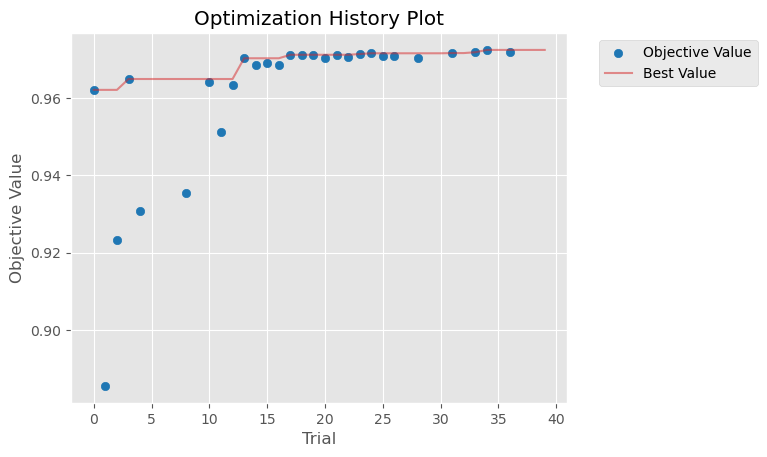

In [50]:
plot_optimization_history(study)
plt.show()

C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\4215324563.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


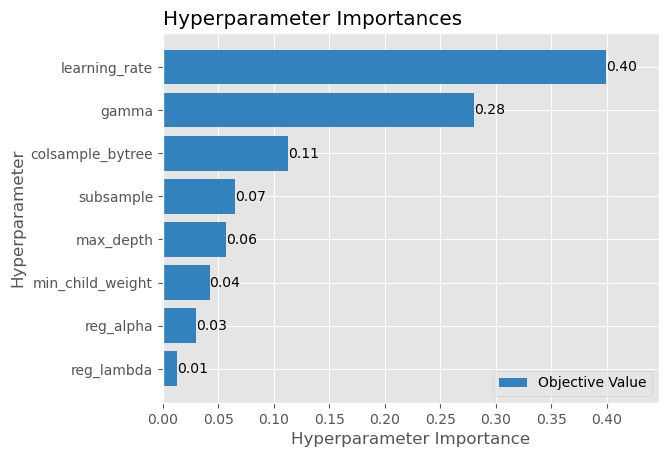

In [51]:
plot_param_importances(study)
plt.show()

C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\3319951807.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(study)


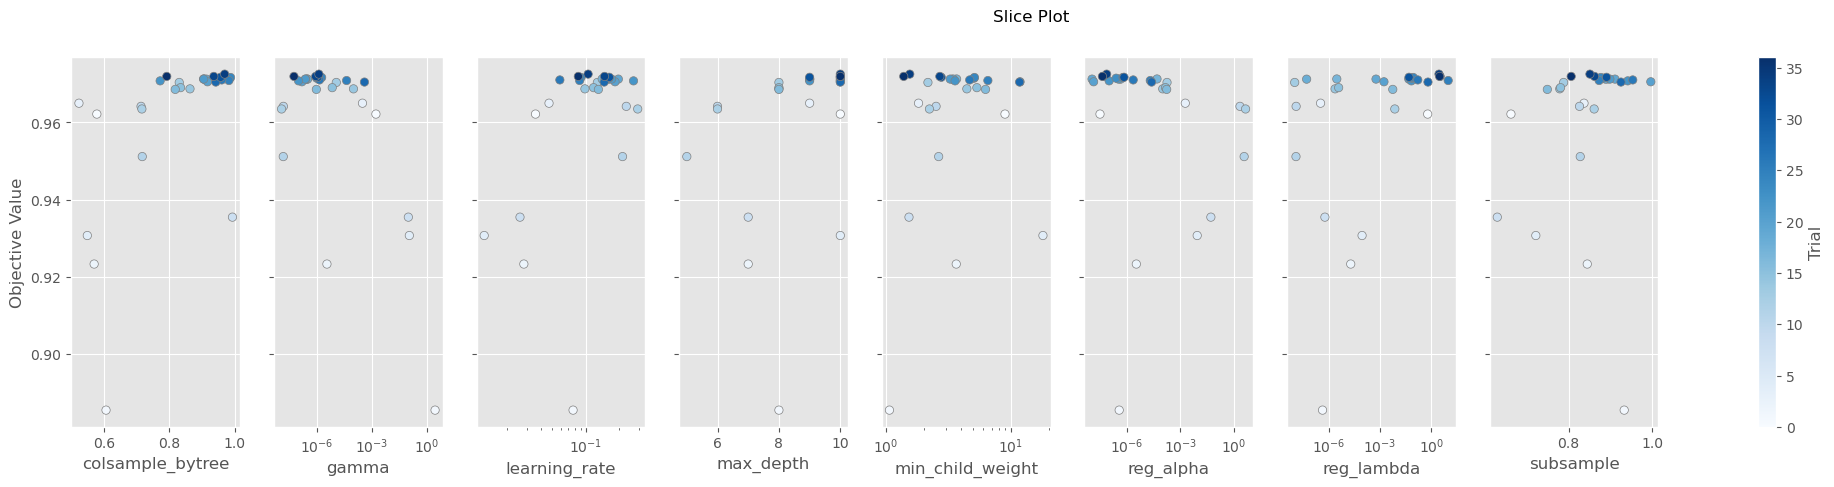

In [54]:
plot_slice(study)
plt.show()

C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\743126399.py:1: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  plot_parallel_coordinate(study)


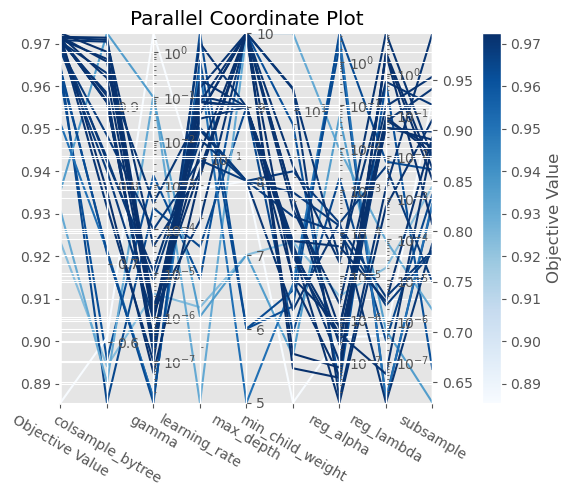

In [56]:
plot_parallel_coordinate(study)
plt.show()

In [57]:
best_params = study.best_trial.params
print("Best hyperparameters:", best_params)

Best hyperparameters: {'learning_rate': 0.10517622125004328, 'max_depth': 10, 'min_child_weight': 1.5473334518374855, 'gamma': 1.2389627831613785e-06, 'subsample': 0.8510678378861979, 'colsample_bytree': 0.9695892587437234, 'reg_alpha': 7.567469385929888e-08, 'reg_lambda': 2.8686226449745407}


In [ ]:
final_model = XGBClassifier(
    **best_params,
    objective="multi:softprob",
    num_class=NUM_CLASSES,
    eval_metric="mlogloss",
    use_label_encoder=False,
)

# If you have a separate validation set for early stopping
final_model.fit(
    X_train, y_train
)

d:\anaconda3\envs\Elevvo\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:49:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9695892587437234
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


Test Accuracy: 0.9028


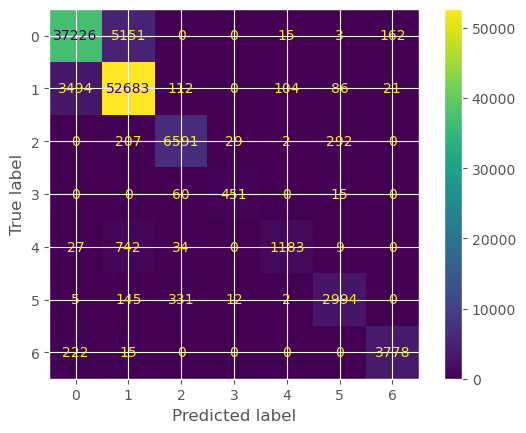

In [ ]:
y_pred = final_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")
# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()
